## Re-weighting: a Monte Carlo $\to$ Data example

Kyle Cranmer, Juan Pavez, Gilles Louppe, March 2016.

It is very common that one has two distributions $p_0(x)$ and $p_1(x)$ and  would like to make one look like the other. This happens for instance in high energy physics where we have a simulation of the data that isn't perfect and we want to make it look like the real data. In this case we are going to "reweight" data from one distribution so that the result looks like the other. For more on this topic, see Alex Rogozhnikov's nice [blog post](http://arogozhnikov.github.io/2015/10/09/gradient-boosted-reweighter.html)

We reuse the data used in Alex Rogozhnikov's [blog post](http://arogozhnikov.github.io/2015/10/09/gradient-boosted-reweighter.html).

We will compare three types of reweighting:
   * reweighting based on Alex's gradient-boosting `GBRweighter`
   * reweighting based on [Approximating Likelihood Ratios with Calibrated Discriminative Classifiers](http://inspirehep.net/record/1377273) using the [carl](https://github.com/diana-hep/carl) package to approximate the likelihood ratio by first training a neural network classifier and then calibrating the output to be the likelihood ratio. Any other type of classifier could also be used.

We will compare the exact weights to the two approximate techniques and use a `discriminator` to distinguish between target and the reweighted distribution using the different techniques.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
#plt.set_cmap("viridis")

import numpy as np
import theano
from scipy.stats import chi2
from itertools import product
import root_numpy
import hep_ml
import pandas as pd

np.random.seed(314)

In [29]:
#some flags for the running below

#the example has much more real data than monte carlo
#this leads to unbalanced dataset
#some techniques deal with that better than others
data_to_use = ["all","max balanced"][1]

#if you use all the data the classifier score can be very peaked
#some classifiers can use weights (eg. the ExtraTreesRegressor)
#and that will make the distribution less peaked.
clf_type = ["mlp","trees","trees with weights"][0]

# the histogram and kde calibration don't work very well
#with very peaked output score distributions,
#but the isotonic approach does
calibration_type = ["isotonic", "kde", "histogram"][1]

### Get the data

In [30]:
storage = 'https://github.com/arogozhnikov/hep_ml/blob/data/data_to_download/'
import urllib
#urllib.urlretrieve ('{0}/MC_distribution.root?raw=true'.format(storage), "MC_distribution.root")
#urllib.urlretrieve ('{0}/RD_distribution.root?raw=true'.format(storage), "RD_distribution.root")
!wget -O data/MC_distribution.root -nc $storage/MC_distribution.root?raw=true
!wget -O data/RD_distribution.root -nc $storage/RD_distribution.root?raw=true

File `data/MC_distribution.root' already there; not retrieving.
File `data/RD_distribution.root' already there; not retrieving.


In [31]:
columns = ['hSPD', 'pt_b', 'pt_phi', 'vchi2_b', 'mu_pt_sum']

original = root_numpy.root2array('data/MC_distribution.root', branches=columns)
target = root_numpy.root2array('data/RD_distribution.root', branches=columns)

original = pd.DataFrame(original)
target = pd.DataFrame(target)

X0_all = original.values
X1_all = target.values
print(X0_all.shape)
print(X1_all.shape)

(1000000, 5)
(21441, 5)


In [32]:
#make training data from all samples
num1 = X0_all.shape[0]
num2 = X1_all.shape[0]
X_all = np.vstack((
     X0_all,
     X1_all))
y_all = np.zeros(num1 + num2, dtype=np.int)
y_all[num1:] = 1

#weight X0 or X1 so weighted samples are balanced
training_weights=np.ones(num1+num2)
#if num1>num2 apply weight < 1 to the num1 samples
training_weights[:num1] = np.minimum(1.,1.*num2/num1)
#vice versa
training_weights[num1:] = np.minimum(1.,1.*num1/num2)

#randomly sample X0 to have the same number of entries as X1
# assuming X0 is bigger here
X0_s = X0_all[np.random.choice(range(X0_all.shape[0]),num2,replace=False)]
X_s = np.vstack((
     X0_s,
     X1_all))
y_s = np.zeros(num2 + num2, dtype=np.int)
y_s[num2:] = 1

#now use the flags to decide which of the datasets to use
X, X0, X1, y = None, None, None, None
if data_to_use == "all":
    X, X0, X1, y = X_all, X0_all, X1_all, y_all
elif data_to_use == "max balanced":
    X, X0, X1, y = X_s, X0_s, X1_all, y_s
else:
    print("error")
    
print(X0.shape)
print(X1.shape)

(21441, 5)
(21441, 5)


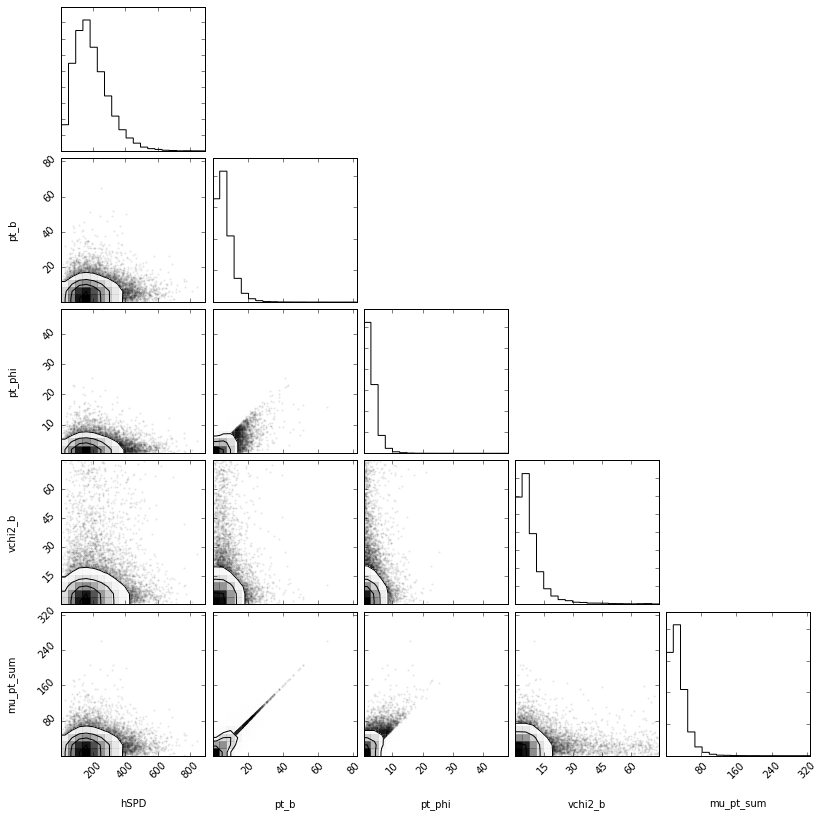

In [33]:
#plot the data
import corner
fig = corner.corner(X0, bins=20, smooth=0.85, labels=columns)

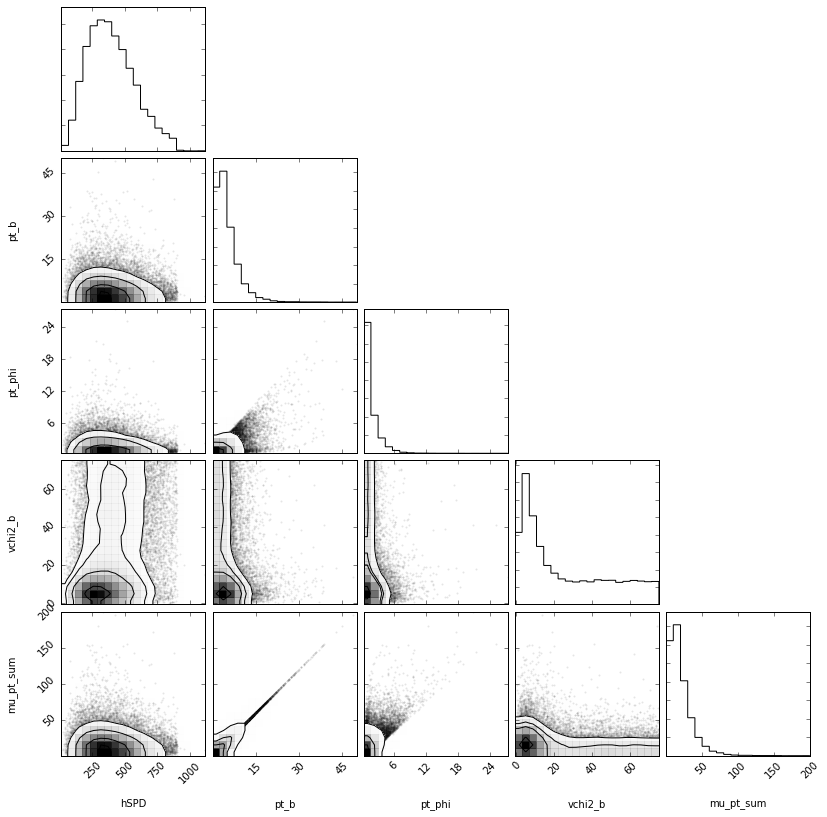

In [34]:
fig = corner.corner(X1, bins=20, smooth=0.85, labels=columns)

### make a helper function for plotting the re-weighted data

In [35]:
hist_settings = {'bins': 50, 'normed': True, 'alpha': 0.3}
def draw_distributions(weights=np.ones(X0[:,0].size)):
    plt.figure(figsize=(16, 8))
    columns = range(5)
    for id, column in enumerate(columns, 1):
        xlim = np.percentile(np.hstack(X1[:,column]), [0.01, 99.99])
        plt.subplot(2,3, id)
        plt.hist(X0[:,column], weights=weights, range=xlim, color='b',**hist_settings)
        plt.hist(X1[:,column], range=xlim, color='orange',**hist_settings)
        plt.xlabel('X%d' %(id))

### The unweighted 1-d distributions

Clearly the distributions look different

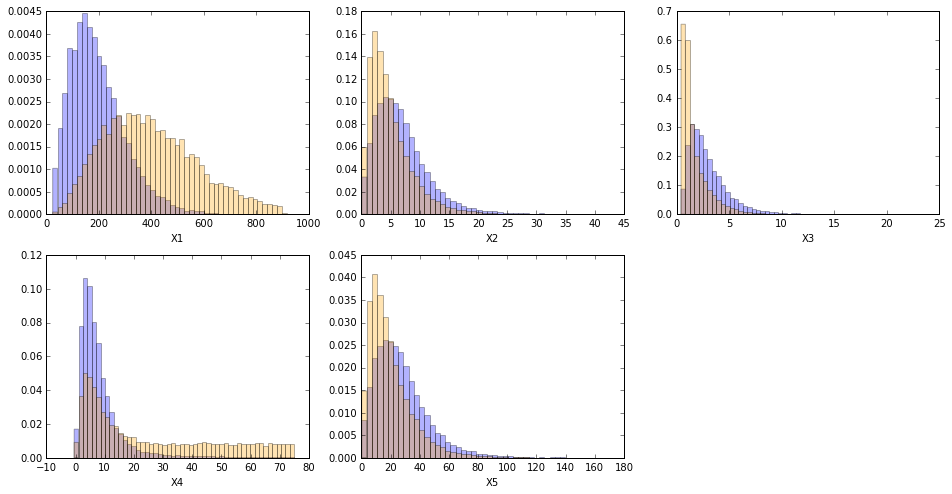

In [36]:
draw_distributions(np.ones(X0[:,0].size))

### Gradient-boost re-weighting from hep_ml

See Alex Rogozhnikov's (Алексей Михайлович Рогожников)'s nice [blog post](http://arogozhnikov.github.io/2015/10/09/gradient-boosted-reweighter.html)

See also the [hep_ml documentation](https://arogozhnikov.github.io/hep_ml/reweight.html) for the tool.


And here is a [demo notebook](https://github.com/arogozhnikov/hep_ml/blob/master/notebooks/DemoReweighting.ipynb) similar to this one.

In [37]:
from hep_ml import reweight

In [38]:
reweighter = reweight.GBReweighter(n_estimators=50, learning_rate=0.1, max_depth=3, min_samples_leaf=1000, 
                                   gb_args={'subsample': 0.6})
reweighter.fit(X0, X1)

gb_weights = reweighter.predict_weights(X0)


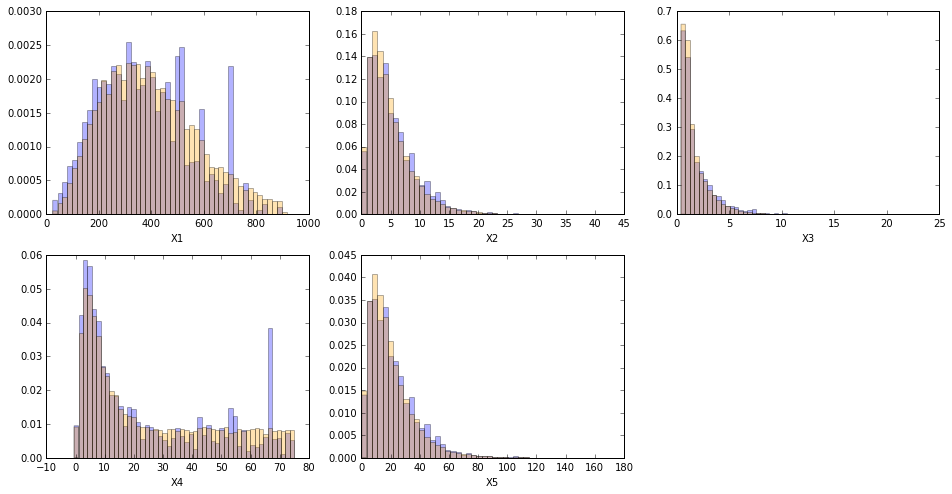

In [39]:
#print gb_weights
draw_distributions(gb_weights)

That looks pretty good, but of course those are 1-d projections. Later in the notebook we will train a classifier to try to distinguish the target and the reweighted distributions. But first, lets look at a scatter plot of the exact weights and the weights from the `GBReweighter`.

### Approximate likelihood ratio with classifiers

This approach is based on [Approximating Likelihood Ratios with Calibrated Discriminative Classifiers](http://inspirehep.net/record/1377273). 

We will use the [carl](https://github.com/diana-hep/carl) package to approximate the likelihood ratio by first training a neural network classifier and then calibrating the output to be the likelihood ratio. Any other type of classifier could also be used.

In [40]:
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier

# other classifiers from scikit-learn that you could also use
#from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import ExtraTreesRegressor

# for calibration
from sklearn.model_selection import StratifiedShuffleSplit
from carl.ratios import ClassifierRatio
from carl.learning import CalibratedClassifierCV

In [41]:
from carl.learning import as_classifier

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


# configure the classifier and train it
classifier = None
if clf_type == "mlp":
    classifier = make_pipeline(StandardScaler(),
                   as_classifier(MLPRegressor(tol=1e-05, activation="logistic", 
                   hidden_layer_sizes=(10, 10), learning_rate_init=1e-07, 
                   learning_rate="constant", algorithm="l-bfgs", random_state=1, 
                   max_iter=75)))
    classifier.fit(X,y) 


elif clf_type =="trees":
    classifier = make_pipeline(StandardScaler(),
                       as_classifier(ExtraTreesRegressor(n_estimators=250, max_leaf_nodes=15)))
    classifier.fit(X,y) # unbalanced data
    
elif clf_type == "trees with weights":

    regressor = ExtraTreesRegressor(n_estimators=250, max_leaf_nodes=15)
    regressor.fit(X,y, sample_weight=training_weights) # unbalanced, weighted data
    classifier = as_classifier(ExtraTreesRegressor(n_estimators=250, max_leaf_nodes=15))
    classifier.regressor_ = regressor

elif clf_type == "trees with weights" and data_to_use == "max balanced":
    print("not implemented, use all data right now")

else:
    print("configuration error")

ratio = ClassifierRatio(CalibratedClassifierCV(
        base_estimator=classifier, 
        cv="prefit",  # keep the pre-trained classifier
        method=calibration_type, bins=50))

# now train calibrate the ratio 
ratio.fit(X=X, y=y, n_samples=y.size) 



ClassifierRatio(base_estimator=CalibratedClassifierCV(base_estimator=Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('wrapper', Wrapper(base_estimator=MLPRegressor(activation='logistic', algorithm='l-bfgs', alpha=0.0001,
       batch_size='auto', beta_1=0.9, beta_2=0.9...erbose=False,
       warm_start=False)))]),
            bins=50, cv='prefit', eps=0.1, method='kde'),
        random_state=None)

In [42]:
# get the weights
carl_weights = 1./ratio.predict(X0) #current configuration gives p0/p1 not p1/p0

In [43]:
X.shape, y.shape, training_weights.shape

((42882, 5), (42882,), (1021441,))

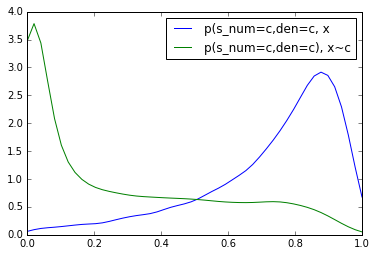

In [44]:
if hasattr(ratio.classifier_, "calibrators_"): 
    reals2 = np.linspace(0, 1)

    cal_num, cal_den = ratio.classifier_.calibrators_[0]
    plt.plot(reals2, cal_num.pdf(reals2.reshape(-1, 1)), 
             label="p(s_num=c,den=c, x")
    plt.plot(reals2, cal_den.pdf(reals2.reshape(-1, 1)), 
            label="p(s_num=c,den=c), x~c")
    plt.legend()
    plt.show()
else:
    print("can't make this plot. probably using isotonic calibration")

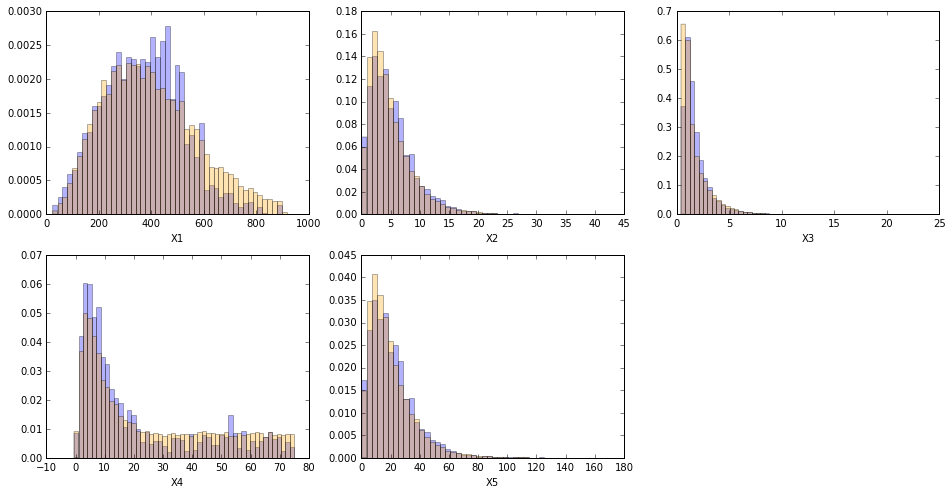

In [45]:
#print carl_weights
draw_distributions(carl_weights)

## ROC curves for quantitative assessment of performance

We want to quantify how well the reweighted distribution matches target distribution, but this is challenging in high dimensions. So we will train a new classifier, call it the *discriminator*, that will try to predict if an event is from the reweighted distribution or the real target. If it can tell the difference, then we haven't done a good job in reweighting. If we have done a good job in reweighting, then we don't expect that it will be able to tell the difference and the ROC curve should just be a diagonal line with Area Under the Curve (AUC) of 0.5. 

*Note*: This is similar to the use of the discriminator in the paper [Generative Adversarial Nets](http://arxiv.org/abs/1406.2661).

In [46]:
from sklearn.metrics import roc_curve, auc
def makeROC(predictions,targetdata):
    fpr, tpr, _  = roc_curve(targetdata.ravel(),predictions.ravel())
    roc_auc = auc(fpr, tpr)
    return fpr,tpr,roc_auc

In [47]:
# obtain data from r*p1 by resampling data from p1 using r as weights
# fix conventions of p0 vs. p1 reweighting
def weight_data(x0,x1,weights):
    x1_len = x1.shape[0]
    x0_len = x0.shape[0]

    weights = weights / weights.sum()
    weighted_data = np.random.choice(range(x0_len), x0_len, p = weights)
    w_x0 = x0.copy()[weighted_data]
    y = np.zeros(x1_len + x0_len)
    x_all = np.vstack((w_x0,x1))
    y_all = np.zeros(x1_len +x0_len)
    y_all[x0_len:] = 1
    return (x_all,y_all)

# generate some new data to make the ROC curve.
# if we used the same data we might be fooled by overfitting
n_for_roc = np.minimum(X0.shape[0], X1.shape[0])
X0_roc = X0[np.random.choice(range(X0.shape[0]),n_for_roc,replace=False)]
X1_roc = X1[np.random.choice(range(X1.shape[0]),n_for_roc,replace=False)]
#X0_roc = X0
#X1_roc = X1
y_roc = np.zeros(X0_roc.shape[0]+X1_roc.shape[0], dtype=np.int)
y_roc[X0_roc.shape[0]:] = 1

# Weighted with approximate likelihood ratios from carl
carl_weights_roc = 1./ratio.predict(X0_roc,log=False)
carl_weights_roc[np.isinf(carl_weights_roc)] = 0.
roc_data_carl_weights = weight_data(X0_roc,X1_roc,carl_weights_roc)

# Weighted with GB ratios
gb_weights_roc = reweighter.predict_weights(X0_roc)
gb_weights_roc[np.isinf(gb_weights_roc)] = 0.
roc_data_gb_weights = weight_data(X0_roc,X1_roc,gb_weights_roc)

In [48]:
X0_roc.shape, carl_weights_roc.shape

((21441, 5), (21441,))

(0, 5)

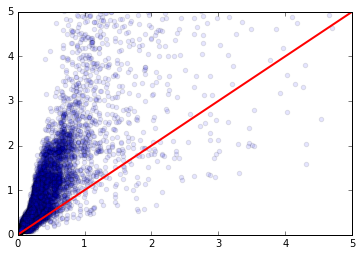

In [53]:
plt.scatter(gb_weights_roc,carl_weights_roc, alpha=0.1)
max_temp=5
plt.plot([0,max_temp],[0,max_temp], lw=2, c='r')
plt.xlim(0,max_temp)
plt.ylim(0,max_temp)

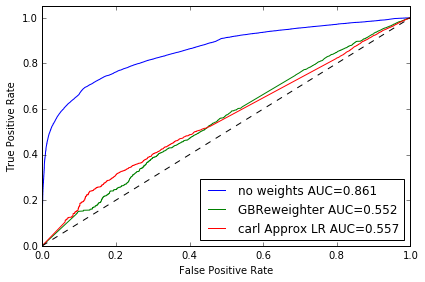

In [54]:
discriminator = MLPRegressor(tol=1e-05, activation="logistic", 
               hidden_layer_sizes=(10, 10), learning_rate_init=1e-07, 
               learning_rate="constant", algorithm="l-bfgs", random_state=1, 
               max_iter=75)

#discriminator.fit(roc_data_exact_weights[0],roc_data_exact_weights[1])
#predicted = discriminator.predict(roc_data_exact_weights[0])
#fpr_t,tpr_t,roc_auc_t = makeROC(predicted, roc_data_exact_weights[1])
#plt.plot(fpr_t, tpr_t, label=r"exact weights AUC=%.3f" % roc_auc_t)

discriminator.fit(np.vstack((X0_roc,X1_roc)),y_roc)
predicted = discriminator.predict(np.vstack((X0_roc,X1_roc)))
fpr_f,tpr_f,roc_auc_f = makeROC(predicted, y_roc)
plt.plot(fpr_f, tpr_f, label=r"no weights AUC=%.3f" % roc_auc_f)

discriminator.fit(roc_data_gb_weights[0],roc_data_gb_weights[1])
predicted = discriminator.predict(roc_data_gb_weights[0])
fpr_a,tpr_a,roc_auc_a = makeROC(predicted, roc_data_gb_weights[1])
plt.plot(fpr_a, tpr_a, label=r"GBReweighter AUC=%.3f" % roc_auc_a)

discriminator.fit(roc_data_carl_weights[0],roc_data_carl_weights[1])
predicted = discriminator.predict(roc_data_carl_weights[0])
fpr_a,tpr_a,roc_auc_a = makeROC(predicted, roc_data_carl_weights[1])
plt.plot(fpr_a, tpr_a, label=r"carl Approx LR AUC=%.3f" % roc_auc_a)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.tight_layout()

plt.show()